In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.special import binom
import pandas as pd
import math
import pickle

## Intervale de confidenţă T

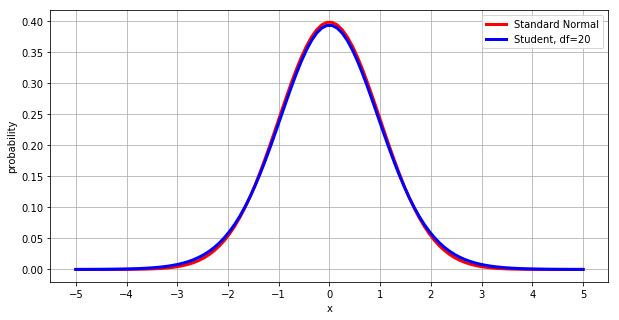

In [2]:
mu = 0
variance = 1
sigma = math.sqrt(variance)
x = np.linspace(mu - 5*sigma, mu + 5*sigma, 100)
y_n = stats.norm.pdf(x, loc=mu, scale=variance)
y_t = stats.t.pdf(x, df=20)

plt.figure(figsize=(10,5))
plt.plot(x, y_n, lw=3, c='r')
plt.plot(x, y_t, lw=3, c='b')
plt.legend(['Standard Normal', 'Student, df=20'])
plt.grid()
plt.xticks(np.linspace(mu-5*sigma, mu+5*sigma, 11))
plt.xlabel('x')
plt.ylabel('probability')
#plt.axvline(x=mu, c='b', linestyle='--')
#[plt.axvline(x=mu_, c='g', linestyle='--') for mu_ in [mu-1, mu+1]]
plt.show()

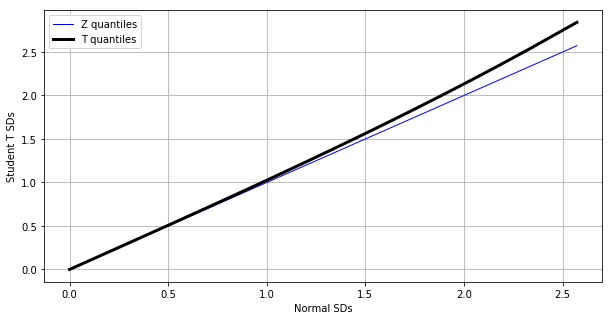

In [3]:
mu = 0
variance = 1
sigma = math.sqrt(variance)
x = np.linspace(mu - 5*sigma, mu + 5*sigma, 100)
#y_n = stats.norm.pdf(x, loc=mu, scale=variance)
#y_t = stats.t.pdf(x, df=20)
q = np.linspace(0.5, 1.0, 100)
n_q = stats.norm.ppf(q, loc=0, scale=1)
t_q = stats.t.ppf(q, df=20)

plt.figure(figsize=(10,5))
plt.plot(n_q, n_q, lw=1, c='b')
plt.plot(n_q, t_q, lw=3, c='k')
plt.grid()
plt.xticks(np.linspace(0, 2.5, 6))
#plt.yticks(np.linspace(0, 2.5, 6))
plt.legend(['Z quantiles', 'T quantiles'])
plt.xlabel('Normal SDs')
plt.ylabel('Student T SDs')
plt.show()

In [4]:
sleep = pd.read_csv('sleep.csv')
sleep.head()

,Unnamed: 0,extra,group,ID
0,1,0.7,1,1
1,2,-1.6,1,2
2,3,-0.2,1,3
3,4,-1.2,1,4
4,5,-0.1,1,5


In [5]:
sleep[sleep.group==1].head()

,Unnamed: 0,extra,group,ID
0,1,0.7,1,1
1,2,-1.6,1,2
2,3,-0.2,1,3
3,4,-1.2,1,4
4,5,-0.1,1,5


In [6]:
sleep[sleep.group==2].head()

,Unnamed: 0,extra,group,ID
10,11,1.9,2,1
11,12,0.8,2,2
12,13,1.1,2,3
13,14,0.1,2,4
14,15,-0.1,2,5


In [7]:
sleep1 = sleep[sleep.group==1]\
    .set_index('ID')\
    .join(
        sleep[sleep.group==2].set_index('ID'),
        lsuffix='_before',
        rsuffix='_after'
    )
sleep1

,Unnamed: 0_before,extra_before,group_before,Unnamed: 0_after,extra_after,group_after
ID,,,,,,
1,1,0.7,1,11,1.9,2
2,2,-1.6,1,12,0.8,2
3,3,-0.2,1,13,1.1,2
4,4,-1.2,1,14,0.1,2
5,5,-0.1,1,15,-0.1,2
6,6,3.4,1,16,4.4,2
7,7,3.7,1,17,5.5,2
8,8,0.8,1,18,1.6,2
9,9,0.0,1,19,4.6,2


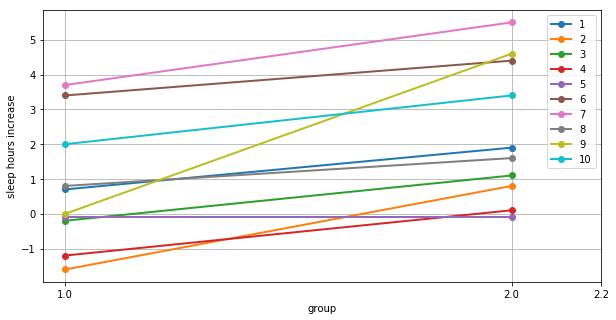

In [8]:
plt.figure(figsize=(10,5))
y1 = sleep1['extra_before'].values
y2 = sleep1['extra_after'].values
x = [1, 2]
ys = [[y1[i], y2[i]] for i in range(len(y1))]
[plt.plot(x, ys[i], marker='o', lw=2) for i in range(len(y1))]
plt.grid()
plt.xlabel('group')
plt.ylabel('sleep hours increase')
plt.legend(range(1,11))
plt.xticks([1, 2, 2.2])
plt.show()

In [9]:
# A/B paired group testing
diff = y2 - y1
m = np.mean(diff); s = np.std(diff)
print(m + np.array([-1, 1]) * stats.t.ppf(0.975, df=9) * s / np.sqrt(10))
print(stats.t.interval(0.95, loc=m, scale=s/np.sqrt(10), df=9))

[0.74526707 2.41473293]
(0.7452670722078104, 2.4147329277921896)


In [10]:
# independent group A/B testing, equal variances
x_oc, s_oc = 132.86, 15.34
x_c, s_c = 127.44, 18.23
n_oc, n_c = 8, 21
sp = np.sqrt( ((n_oc-1)*s_oc**2 + (n_c-1)*s_c**2) / (n_oc+n_c-2) )
print(x_oc - x_c + np.array([-1, 1]) * stats.t.ppf(.975, df=n_oc+n_c-2) \
    * sp * (1/n_oc+1/n_c)**.5)
print(stats.t.interval(
    0.95, 
    loc = x_oc - x_c, 
    scale = sp * (1/n_oc+1/n_c)**.5, 
    df=n_oc+n_c-2
))

[-9.52109748 20.36109748]
(-9.521097483796161, 20.361097483796193)


In [11]:
# independent group A/B testing vs. paired A/B testing
# sleep data
y1 = sleep1['extra_before'].values
y2 = sleep1['extra_after'].values

x_1, s_1 = np.mean(y1), np.std(y1)
x_2, s_2 = np.mean(y2), np.std(y2)
n = len(y1)
sp = np.sqrt( (s_1**2 + s_2**2) / 2 )
print(x_2 - x_1 + np.array([-1, 1]) * stats.t.ppf(.975, df=2*n-2) \
    * sp * np.sqrt(2/n))
print(stats.t.interval(0.95, loc=m, scale=s/np.sqrt(10), df=9))

[-0.1123315  3.2723315]
(0.7452670722078104, 2.4147329277921896)


In [12]:
# independent group A/B testing, unequal variances
# oral contraceptive example
x_oc, s_oc = 132.86, 15.34
x_c, s_c = 127.44, 18.23
n_oc, n_c = 8, 21
df = (s_oc**2/n_oc + s_c**2/n_c)**2 / \
    ( (s_oc**2/n_oc)**2/(n_oc-1) + (s_c**2/n_c)**2/(n_c-1) )
print('df: ', df)
sp = np.sqrt( s_oc**2/n_oc + s_c**2/n_c )
print(x_oc - x_c + np.array([-1, 1]) * stats.t.ppf(.975, df=df) * sp)
print(stats.t.interval(
    0.95,
    loc = x_oc - x_c, 
    scale = np.sqrt(s_oc**2/n_oc + s_c**2/n_c), 
    df=df
))

df:  15.035180011917006
[-8.91332743 19.75332743]
(-8.913327425893712, 19.753327425893744)


## Testarea ipotezei

In [13]:
# paired T test pentru father.son dataset
father_son = pd.read_csv('father_son.csv')
father_son.head()

,Unnamed: 0,fheight,sheight
0,1,65.04851,59.77827
1,2,63.25094,63.21404
2,3,64.95532,63.34242
3,4,65.75250,62.79238
4,5,61.13723,64.28113


In [14]:
# calculăm diferenţa dintre înălţimi
fs = father_son['sheight'].values - father_son['fheight'].values

# statistica, (X' - mean_pop)/std_sample/sqrt(sample length)
# atentie la calculul standard error, se face pe n-1, unde 
# n este dimensiunea sample-ului
print((np.mean(fs) - 0)*np.sqrt(len(fs))/np.std(fs, ddof=1))

# folosim paired (related) T test pentru a calcula statistica
# ipoteza H_0 este ca mediile celor doua populatii sa nu difere
print(stats.ttest_rel(
    father_son['sheight'].values, 
    father_son['fheight'].values\
).statistic)

# alternativ avem si one sample T test, specificam media populatiei
# ipoteza H_0 este ca media diferentelor sa fie 0
print(stats.ttest_1samp(
    father_son['sheight'].values - father_son['fheight'].values,
    popmean=0
).statistic)

11.788549038237015
11.788549038237013
11.788549038237013


In [15]:
# pentru ipoteza H_0, dacă ea e adevarata (diferenta e zero),
# în 95% din cazuri media va fi sub 1.6463
print(stats.t.ppf(0.95, df=len(fs)-1))

# putem calcula si intevalul T de confidenta 95% pentru media populatiei:
print(stats.t.interval(
    0.95, 
    loc = np.mean(fs), 
    scale = np.std(fs, ddof=1)/np.sqrt(len(fs)), 
    df=len(fs)-1
))

# se vede ca:
# 1) satistica 11.78 > 1.64, rejectam H_0
# 2) zero nu intra in acest interval
# 3) df = 1077, distributia e aproape normala

1.6462696795616023
(0.831029622612876, 1.1629159618027087)


In [16]:
# rata de evenimente respiratorii revizitata
print('statistic: ', (32 - 30)*np.sqrt(16)/10)
print('95% percentile:', stats.t.ppf(0.95, df=15))
print('reject H_0' 
      if (32 - 30)*np.sqrt(16)/10 > stats.t.ppf(0.95, df=15) 
      else 'fail to reject H_0'
)
print('verificare: media poate fi in intevalul\n\t',
    stats.t.interval(
        0.95, 
        loc = 30, 
        scale = 32/np.sqrt(16), 
        df=15
    )
)

statistic:  0.8
95% percentile: 1.7530503556925547
fail to reject H_0
verificare: media poate fi in intevalul
	 (12.948403635525416, 47.051596364474584)


In [17]:
# oral contraceptive example - independent test,unequal variances
x_oc, s_oc, n_oc = 132.86, 15.34, 8
x_c, s_c, n_c = 127.44, 18.23, 21
df = (s_oc**2/n_oc + s_c**2/n_c)**2 / \
    ( (s_oc**2/n_oc)**2/(n_oc-1) + (s_c**2/n_c)**2/(n_c-1) )
sp = np.sqrt( s_oc**2/n_oc + s_c**2/n_c )

statistic = stats.ttest_ind_from_stats(
    x_oc, s_oc, n_oc, x_c, s_c, n_c, equal_var=False).statistic
print('df: ', df) ; print('statistic: ', statistic)
percentile = stats.t.ppf(0.95, df=df)
print('95% percentile:', percentile)
print('reject H_0' if statistic > percentile else 'fail to reject H_0')
print('T confidence interval: ', stats.t.interval(
    0.95, loc = x_oc - x_c, scale = np.sqrt(s_oc**2/n_oc + s_c**2/n_c), df=df
))
print('two group population mean: ', 0)

df:  15.035180011917006
statistic:  0.805821448286547
95% percentile: 1.7527810366681962
fail to reject H_0
T confidence interval:  (-8.913327425893712, 19.753327425893744)
two group population mean:  0


Reluăm problema cu acel prieten care are 8 copii, din care 7 sunt fete şi nici unele gemene. 

Realizaţi testarea ipotezei $H_0$ : p = 0.5, $H_a$ : p > 0.5

Care este regiunea de rejectare relevantă astfel ca probabilitatea de rejectare este mai mică decât 5% ?

Căutăm probabilitatea, considerând $H_0$ adevărată, ca cuplul să aibă 7 sau mai multe fete.

In [18]:
print(pd.DataFrame(list(zip(
    ['[%d : 8]' % i for i in range(0, 9)],
    [round(1 - stats.binom.cdf(i-1, n=8, p=0.5), 4) for i in range(0, 9)]
)), columns=['Rejection Region', 'Type I Error Rate']))

  Rejection Region  Type I Error Rate
0          [0 : 8]             1.0000
1          [1 : 8]             0.9961
2          [2 : 8]             0.9648
3          [3 : 8]             0.8555
4          [4 : 8]             0.6367
5          [5 : 8]             0.3633
6          [6 : 8]             0.1445
7          [7 : 8]             0.0352
8          [8 : 8]             0.0039


Probabilitatea de rejecţie scade sub 5% doar pentru ultimele două tuple.

## P-values

In [19]:
1 - stats.t.cdf(2.5, df=15)

0.012252901623256984

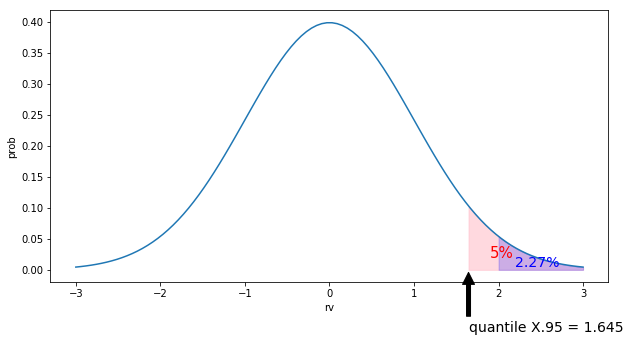

0.02275013194817921

In [20]:
# attained significance level
x = np.linspace(-3, 3, 100)
x1 = np.linspace(1.645, 3, 100)
x2 = np.linspace(2.0, 3, 100)
plt.figure(figsize=(10,5))
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.xlabel('rv')
plt.ylabel('prob')
plt.fill_between(x1, stats.norm.pdf(x1, mu, sigma), color="pink", alpha=0.6)
plt.annotate('5%', xy=(1.9, 0.02), color='r', fontsize=15)
plt.annotate('quantile X.95 = 1.645', 
            xy=(1.645, 0), xytext=(1.645, -.1), fontsize=14, 
            arrowprops = dict(facecolor='black', shrink=0.05))
plt.fill_between(x2, stats.norm.pdf(x2, mu, sigma), color="blue", alpha=0.2)
plt.annotate('2.27%', xy=(2.2, 0.005), color='b', fontsize=14)
plt.show()

1 - stats.norm.cdf(2.0, loc=mu, scale=sigma)

In [21]:
# 7 fete din 8 revisited
print(1 - stats.binom.cdf(6, n=8, p=0.5))
print(stats.binom_test(7, n=8, p=0.5, alternative='greater'))

0.03515625
0.03515625


In [22]:
print(stats.binom_test(7, n=8, p=0.5, alternative='two-sided'))
print(2*stats.binom_test(7, n=8, p=0.5, alternative='greater'))

0.0703125
0.0703125


In [23]:
# infection rate
# distributiile discrete ne dau P(X <= x), de aceea luam de la 9
# avem nevoie de survival function pentru ca e upper tail
1 - stats.poisson.cdf(9, mu=0.05 * 100)

0.03182805730620486

## Laborator: probleme rezolvate

Pentru problemele de calcul, rezolvaţi pe cât posibil folosind cel puţin două metode, ca să vă puteţi verifica.

__Exemplu1__. Rata de omoruri în Scoţia a scăzut anul trecut la 99, de la 115 în anul anterior. Este acest anunţ demn de pomenit în ziar? (Calculaţi intervalul de confidenţă 95% pentru această medie).

Numărul actual de crime variază de la an la an. Dacă presupunem că fiecare este un eveniment independent, atunci putem modela această rată ca o distribuţie Poisson.

In [24]:
# https://www.macs.hw.ac.uk/~rc141/f78sc/notes07.pdf
# vedeti tot materialul de aici, este absolut digerabil

# determinam intervalul de confidenta 95% pentru distributia Poisson cu media populatiei 115.
# media sample-ului e de asteptat ca in 95% din cazuri sa fie intre aceste valori
print('intervalul de confidenta 95%: ', stats.poisson.interval(0.95, mu=115))

# calculam si P-value asociat acestei valori considerate extreme
print('P-value asociat valorii 99: ', stats.poisson.cdf(99, mu=115))

# verificare: daca 94 este valoarea ratei, sub aceasta rata trebuie sa gasim 2.5% din masa distributiei
print('masa distributiei sub 94: ', stats.poisson.cdf(94, mu=115))

intervalul de confidenta 95%:  (94.0, 136.0)
P-value asociat valorii 99:  0.07161185852455393
masa distributiei sub 94:  0.025170549543045425


Ceva cu adevărat interesant ar fi fost dacă rata crimelor ar fi scăzut sub 94 pe an, altfel, se încadrează în variaţia previzibilă. Vedem că această concluzie este indicată de două lucruri:
* valoarea 'record' de 99 este în intervalul de confidenţă, deci previzibilă;
* P-value este peste 5% si vrem sa fie sub, ca să considerăm apariţia unui eveniment extrem.

__Exemplu2__. Un contor Geiger înregistrează 100 de înjumătăţiri radioactive în 5 minute. Găsiţi intervalul de confidenţă 95% pentru numărul de înjumătăţiri pe oră.

In [25]:
# R. https://www.macs.hw.ac.uk/~rc141/f78sc/notes07.pdf
print(np.array(stats.poisson.interval(0.95, mu=100)) * 12)
print(12 * (100 + np.array([-1, 1]) * stats.norm.ppf(0.975) * np.sqrt(100)))

[ 972. 1440.]
[ 964.80432186 1435.19567814]


__Exemplu3__. Presupunem că deviaţia standard a 9 perechi de diferenţe este 1. Care ar fi valoarea mediei diferenţelor astfel ca punctul inferior a intervalului de confidenţă 95% Student T atinge 0?

In [26]:
mu = stats.t.ppf(0.975, df=8)*1/np.sqrt(9) ; print(mu)

# verificare:
stats.t.interval(0.95, loc=mu, scale=1/np.sqrt(9),df=8)

0.7686680450111235


(1.1102230246251565e-16, 1.5373360900222468)

## Laborator: exerciţii şi probleme

__Q1__. $\bar{X}$ şi $\bar{Y}$ sunt calculate ca medii ale $n$ variabile aleatoare iid provenind din distribuţiile cu medii $\mu_x$ şi respectiv $\mu_y$, însă având aceeaşi dispersie $\sigma^2$. Care este dispersia (variance) pentru variabila aleatoare $\bar{X} - \bar{Y}$ ?

R. 

 __Q2__. O variabilă aleatoare ia valoarea -4 cu probabilitatea .2 şi respectiv valoarea 1 cu probabilitatea 0.8. Care sunt media şi dispersia acestei variabile aleatoare?
 
 R.

__Q3__. Considerăm următoarea PMF pentru o variabilă aleatoare:
p = \[.1, .2, .3, .4\]
x = range(2 : 6)

Care este dispersia variabilei aleatoare?

R.

__Q4__. Presupunem că numărul de accesări web pentru un anume site are o distribuţie aproximativ normală de medie 100 de accesări pe zi şi deviaţie standard 10 accesări pe zi. Care este probabilitatea ca într-o zi să avem mai puţin de 93 accesări, exprimată ca procent?

In [27]:
# R. 

__Q5__. Aveţi un prieten care pretinde că poate discerne un vin bun de unul ieftin doar după gust. Deoarece nu îl credeţi, decideţi să-l supuneţi unui test. Presupunând că aveţi dreptate, într-un test dublu orb unde randomizaţi 6 perechi de varietăţi (Merlot, Sauvignon, ...) de vin ieftin şi respectiv vin scump. Care este şansa ca el să ghicească, la întâmplare, 5 sau 6 corect?

In [28]:
# R. 

__Q6__. Numărul de accesări web este distribuit Poisson cu o medie de 16.5 accesări zilnice. Care este probabilitatea de a obţine 20 sau mai puţine în 2 zile?

In [29]:
# R. 

__Q7__. Considerăm dataset-ul father.son. Folosind CLT şi presupunând că taţii sunt un sample random din populaţie, care este intervalul de confidenţă 95% pentru media înălţimii lor?

In [30]:
# R. 

__Q8__. Considerăm o distribuţie uniformă. Extragem 100 de valori din această distribuţie uniformă cu medie 0.5 şi dispersie 1/12 şi calculăm media lor $\bar{X}$. Care este probabilitatea de a obţine o medie mai mare sau egală cu 0.51?

In [31]:
# R. 

__Q9__. Rata de accesări a unui site web este de 10 pe minut, monitorizată timp de o oră. Care este intervalul de confidenţă Poisson a ratei de evenimente pe minut?

In [32]:
# R.

__Q10__. Considerăm datasetul mtcars. Construiţi intervalul T de confidenţă 95% pentru MPG (miles per gallon) comparând maşinile cu 4 respectiv 6 cilindri (diferenţa: setul 4 - setul 6), presupunând aceeaşi dispersie în cele două grupuri.

Observând intervalul de confidenţăm, ce concluzionaţi cu privire la consum?

In [33]:
mtcars = pd.read_csv('mtcars.csv')
mtcars.head()

,Unnamed: 0,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


__Q11__. Considerăm din nou datasetul mtcars. Folosiţi un two group T test pentru a testa ipoteza că cele două grupuri de maşini cu 4 respectiv 6 cilindri au acelaşi consum MPG. Folosiţi un test two sided cu dispersii diferite. Daţi P-value pentru acest two sided test.

__Q12__. Un site web a fost monitorizat pentru un an şi a primit 520 vizite pe zi. În primele 30 de zile ale anului următor, site-ul a primit 15800 vizite. Presupunând că vizitele au o distribuţie Poisson, daţi P-value pentru testul one sided pentru ipoteza că vizitele au sporit faţă de anul trecut. Este rejectată $H_0$? Verificaţi concluzia, calculînd şi intervalul de confidenţă.

__Q13__. Presupunem că facem un test randomizat, dublu orb, cu 18 subiecţi obezi. 9 dintre ei primesc o pastilă de slăbit iar 9 primesc placebo. Indicele de masă corporală (BMI, Body Mass Index) a fost măsurat ca baseline şi apoi în timpul tratamentului, pentru 4 săptămâni. Diferenţa faţă de baseline (followup - baseline) a fost 3 $kg/m^2$ pentru grupul tratat şi 1 $kg/m^2$ pentru grupul placebo. Deviaţiile standard ale diferenţelor au fost de 1.5 $kg/m^2$ pentru grupul tratat şi 1.8 $kg/m^2$ pentru grupul placebo. Studiul doreşte să afle dacă schimbarea BMI după 4 saptămâni este diferită între grupul tratat şi grupul placebo. 

Calculaţi pooled variance şi realizaţi intervalul de confidenţă. Realizaţi apoi two sided test, verificând ipoteza nulă că mediile între grupuri nu diferă. Porniţi de la definirea $H_0$ şi $H_a$ şi calculaţi statistica T pentru intervalul 95%, în două feluri ca să vă verificaţi. Calculaţi şi P-value. Ce concluzie trageţi?

__Q14.__ Aveţi o monedă şi suspectaţi că este biased, că dă mai multe Heads decât Tails. Obţineţi 55 Heads din 100 de aruncări. Daţi valoarea exactă P-value pentru ipoteza ca moneda să fie non-biased (fair). Câte aruncări din 100 trebuie să iasă Heads ca să începeţi să aveţi suspiciuni întemeiate (95% confidenţă)?